In [1]:
import osmnx as ox
import networkx as nx
import matplotlib.colors as colors
import numpy as np
import matplotlib.pyplot as plt
import os

town_name = 'Aubervilliers, FR'
map_size = 5000 # in meters. This is how much "surrounding area" we consider, as measured from the town's centroid

# location to save the maps
file_path = town_name.replace(' ','_')
if not os.path.exists(file_path):
    os.mkdir(file_path) 

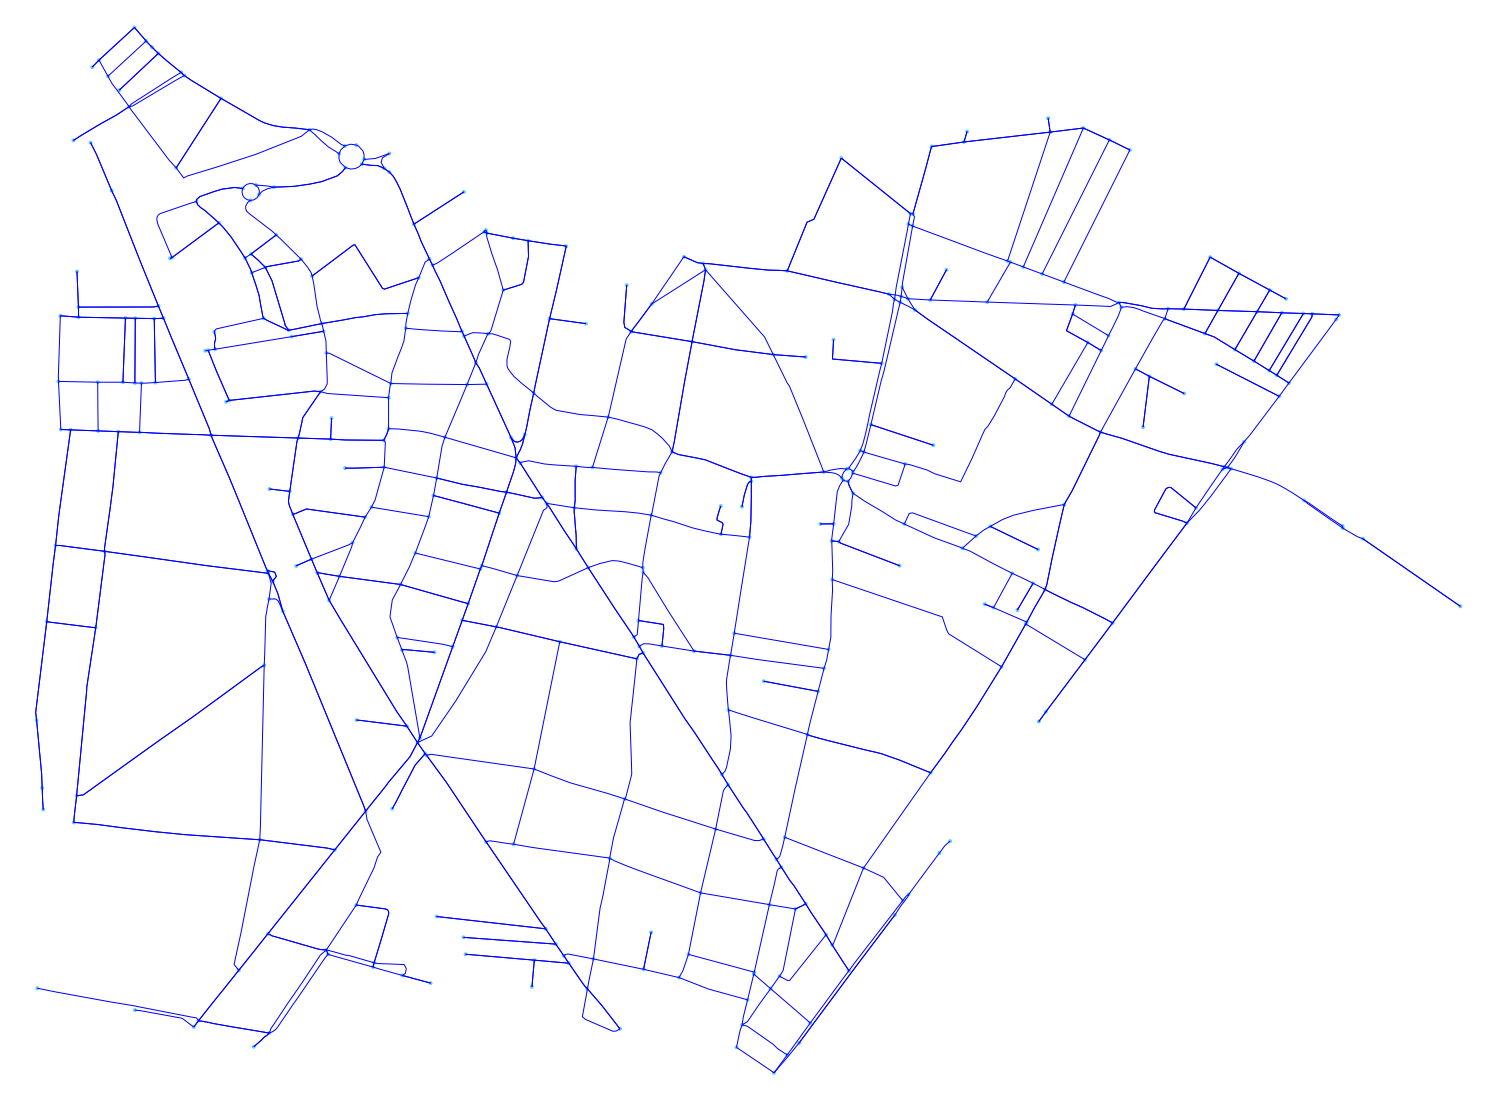

In [2]:
# get the town
town = ox.graph_from_place(town_name, network_type='drive')
# show it, save it
fig, ax = ox.plot_graph(ox.project_graph(town), edge_color='b', fig_height=20)
fig.savefig('%s/town.png' % file_path)
# the town: 

In [3]:
# we want more than the town though, because we care about cutting it off from the outside, so we need to know about 
# the surrounding area.

# get the nodes and edges as data frames 
town_nodes, town_edges = ox.graph_to_gdfs(town)
                              
# get graph centroid and we'll grab everything within in map_size meters of it. For bigger towns this will need to be
# a bigger number.
#todo: can we set this imperically?
x, y = town_edges.unary_union.centroid.xy
graph_centroid = (y[0], x[0])
# G is the surrounding area and the town.
G = ox.graph_from_point(graph_centroid, distance=map_size,  network_type='drive')

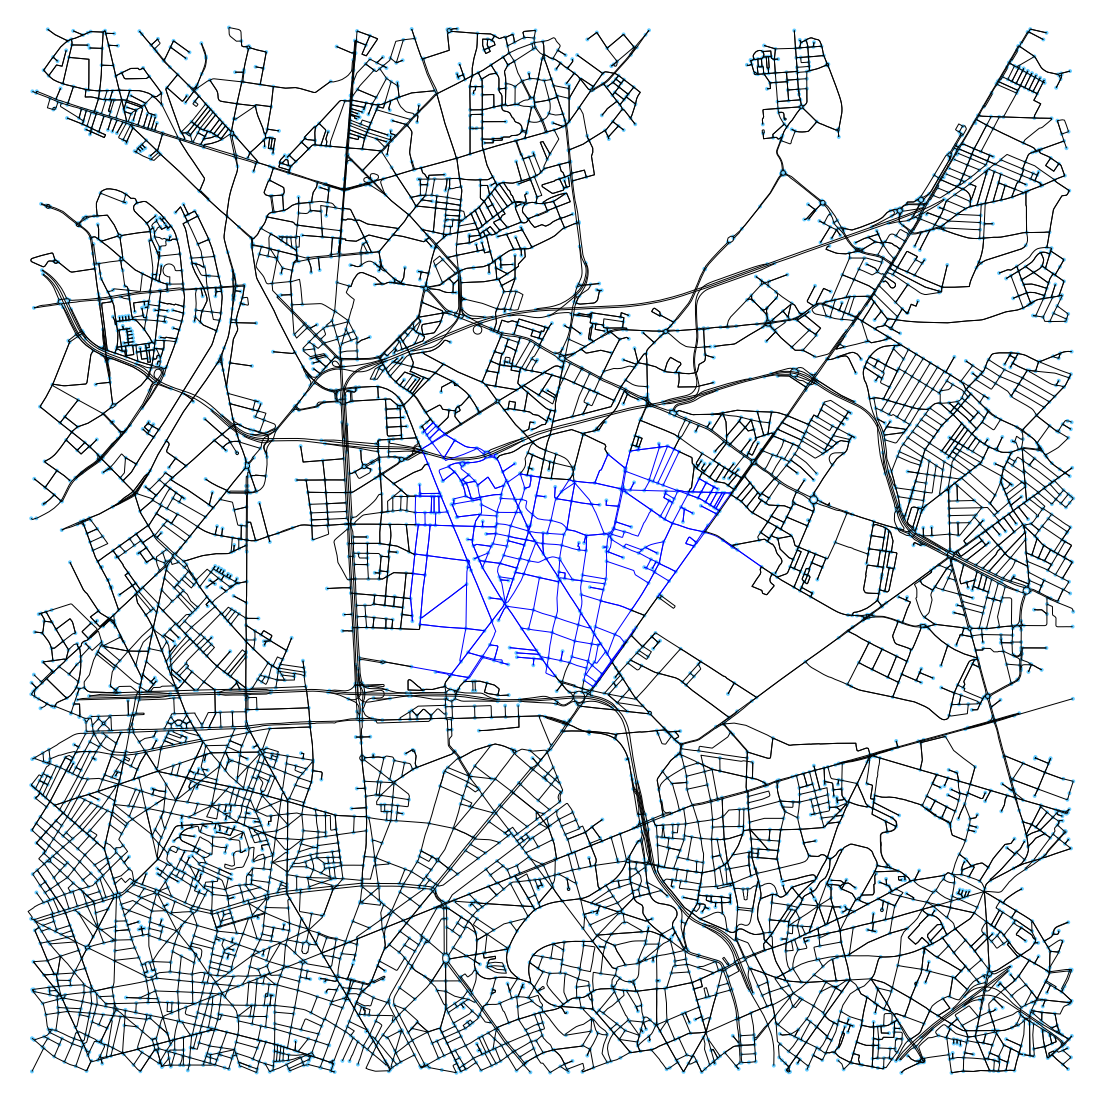

In [4]:
# color the edges in town blue, black out of town
ec = ['b' if e in town.edges() else 'k' for e in G.edges()]
# show it, save it
fig, ax = ox.plot_graph(G, edge_color=ec, fig_height=20)
fig.savefig('%s/area.pdf' % file_path)
# blue is the town


In [5]:
# so now that we have the graph, let's see how to cut it off
# Task 1: isolate the town!
# psudo code:
# for every node in the town
    # if it has an edge to something outside the town:
        # color that edge red!  
# we're working with dataframes though, so we're not gonna use loops here and instead leverage the data structure
nodes, edges = ox.graph_to_gdfs(G) # <- gets the nodes and edges as dataframes

# we want to check which nodes are in town and which aren't, so we make a set to make this fast and easy
town_node_ids = set(town.nodes())

# We want to mark each edge coming into/out of town. That is, each edge where one of it's nodes (u & v)
# is in town and the other out of town
# make a new data frame column for if v is in town (t/f)
edges['v_in_town'] = edges['v'].isin(town_node_ids)
# make a new data frame column for if u is in town
edges['u_in_town'] = edges['u'].isin(town_node_ids)
# make a new data frame column for if both u and v are in town (edges that are completely in town)
edges['in_town'] = edges['v_in_town'] & edges['u_in_town']
# make a new data frame column for the edges (roads) coming in/out of town that we should block
edges['block'] = (edges['v_in_town'] & ~ edges['u_in_town']) | (edges['u_in_town'] & ~ edges['v_in_town'])

# this is how we color code them red if we should block, blue if fully in town, otherwise black
conditions = [(edges['block']), (edges['in_town'])]
choices = ['r', 'b']
edges['edge_color'] = np.select(conditions, choices, default='k')
print('number of edges to block: %d' % (edges['edge_color'].value_counts()['r']))


number of edges to block: 108


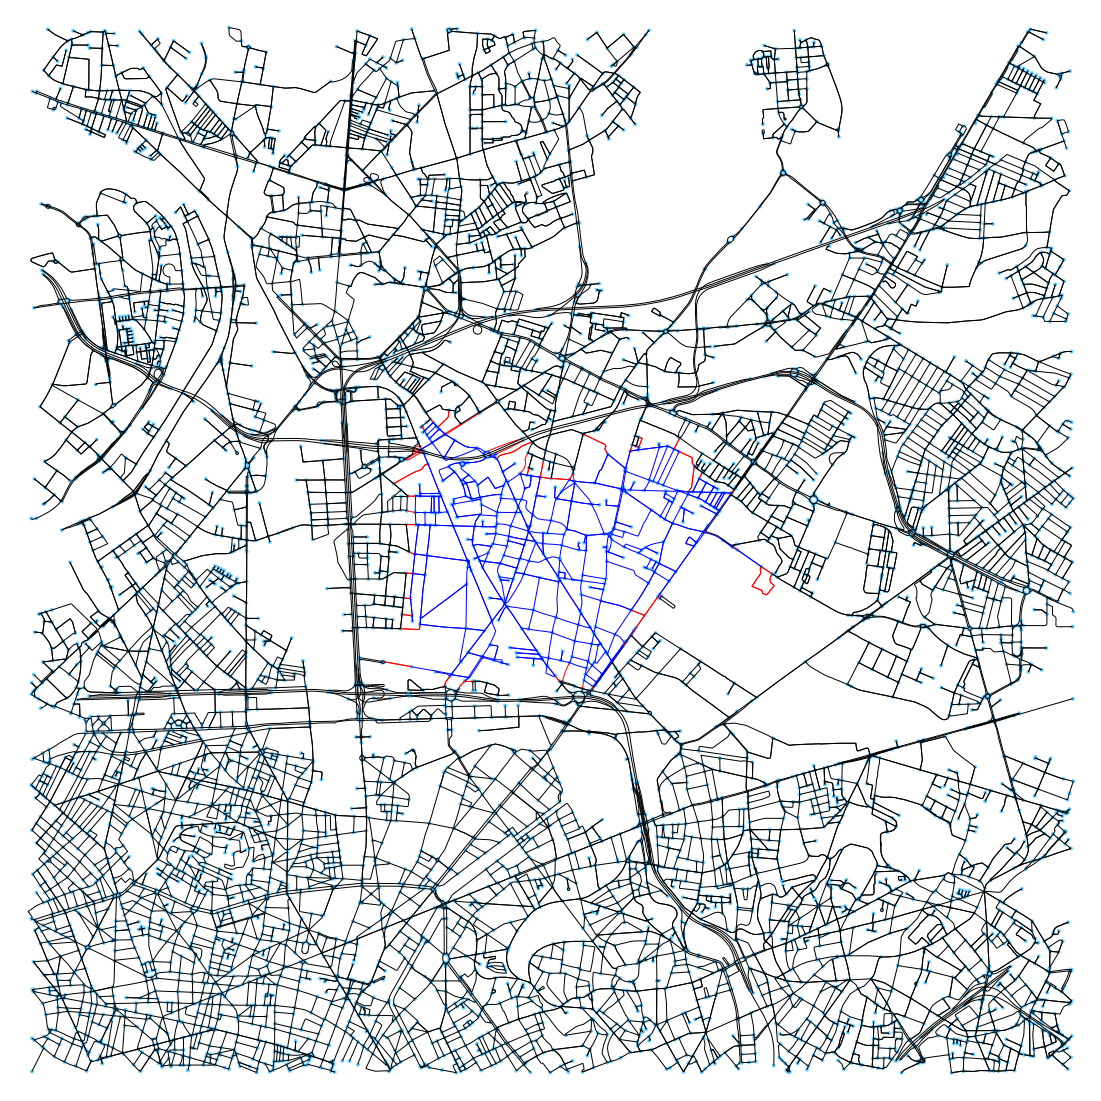


●◜¯¯◝● 
( ●☂● )
 ▀███▀ 
●(¯¯¯) 
 ▄█¯█▄


In [6]:
# turn the dataframes back into a graph
G = ox.gdfs_to_graph(nodes, edges)
# grab the edges, as ordered by G (the correct order is needed for coloring)
nodes, edges = ox.graph_to_gdfs(G)
# show it save it
fig, ax = ox.plot_graph(G, fig_height=20, edge_color=edges['edge_color'])
fig.savefig('%s/isolate.pdf' % file_path, dpi=1000, format='pdf')
panda = '\n●◜¯¯◝● \n( ●☂● )\n ▀███▀ \n●(¯¯¯) \n ▄█¯█▄'
print(panda)